![Alt text](./figures/logo.png)

source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [9]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns

## Reading the CSV file

First lets read the CSV file.

In [ ]:
# Loading and examining the dataset
penguins_df = pd.read_csv("./data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


## Cleaning Data

The uploaded dataset will be assessed to evaluate its quality and ensure it is suitable for analysis. This includes checking for missing values, identifying outliers, and verifying data types and consistency.


In [2]:
df = penguins_df  # Assign a shorter, more convenient variable name for easier handling

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   culmen_length_mm   332 non-null    float64 
 1   culmen_depth_mm    332 non-null    float64 
 2   flipper_length_mm  332 non-null    float64 
 3   body_mass_g        332 non-null    float64 
 4   sex                332 non-null    category
dtypes: category(1), float64(4)
memory usage: 10.9 KB


In [4]:
df['sex'].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [7]:
df['sex']=df['sex'].astype('category')

In [20]:
df.describe(include='category')

,sex
count,332
unique,2
top,MALE
freq,167


In [21]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


- Created a shorter alias `'df'` for the original DataFrame `'penguins_df'` to simplify references.
- Ensured that only non-empty (non-null) rows are considered.
- The `'sex'` column contains only two unique categories: `'MALE'` and `'FEMALE'`.
- Converted the data type of the `'sex'` column to `'category'` for optimised storage and performance.
- No outliers were identified.


## Preliminary Analysis

To generate a preliminary analysis, a relation between the columns was generated with a pairplot.

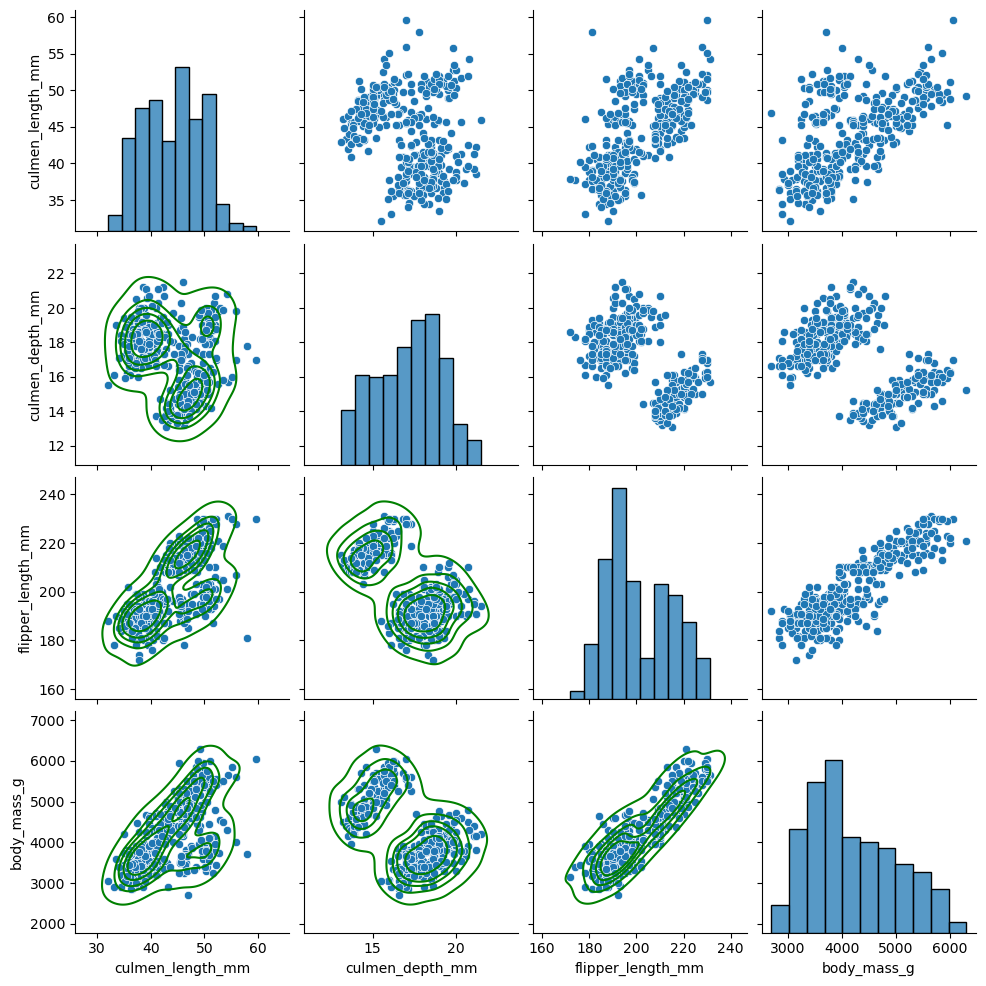

In [28]:
g = sns.pairplot(df)
g.map_lower(sns.kdeplot, levels=6, color="green")
plt.savefig('./plots/pairplot.png')
plt.show()